# 🫀 Heart Disease — Optuna Hyperparameter Tuning
**Tuning XGBoost & CatBoost with multi-objective optimization**
- Maximize global CV AUC
- Minimize Female/Naive false negative rate
- Group-stratified 5-fold CV throughout

---
## 1 · Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

BASE = '/users/clairedebadts/kaggle/heart-disease-playground/data/'


---
## 2 · Load Data & Rebuild Features

In [2]:
df   = pd.read_csv(BASE + 'train_clean.csv')
test = pd.read_csv(BASE + 'test.csv')

def rebuild_groups(data):
    d = data.copy()
    d['sex_label'] = d['Sex'].map({1: 'Male', 0: 'Female'})
    d['under_surveillance'] = (
        (d['Number of vessels fluro'] > 0) |
        (d['Thallium'] == 6) |
        (d['EKG results'] == 2)
    ).astype(int)
    d['group'] = d['sex_label'] + ' / ' + d['under_surveillance'].map({0:'Naive', 1:'Surveilled'})
    return d

def engineer_features(data):
    d = data.copy()
    d['sex_x_chest_pain']   = d['Sex'] * d['Chest pain type']
    d['sex_x_slope']        = d['Sex'] * d['Slope of ST']
    d['sex_x_max_hr']       = d['Sex'] * d['Max HR']
    d['surv_x_cholesterol'] = d['under_surveillance'] * d['Cholesterol']
    d['surv_x_max_hr']      = d['under_surveillance'] * d['Max HR']
    d['surv_x_bp']          = d['under_surveillance'] * d['BP']
    d['hr_reserve']         = (220 - d['Age']) - d['Max HR']
    return d

df   = rebuild_groups(df)
df   = engineer_features(df)
test = rebuild_groups(test)
test = engineer_features(test)

FEATURE_COLS = [c for c in df.columns if c not in
                ['id', 'target', 'sex_label', 'group', 'Heart Disease', 'sample_weight']]

X      = df[FEATURE_COLS].copy()
y      = df['target']
groups = df['group']

weight_map = {
    'Female / Naive':      4.0,
    'Female / Surveilled': 2.0,
    'Male / Naive':        1.5,
    'Male / Surveilled':   1.0,
}
sample_weights = groups.map(weight_map)

N_FOLDS       = 5
skf           = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
group_encoded = pd.Categorical(groups).codes

print(f'Train: {df.shape} | Features: {len(FEATURE_COLS)}')
print(df['group'].value_counts())


Train: (630000, 25) | Features: 21
group
Male / Surveilled      296965
Male / Naive           153318
Female / Naive          90432
Female / Surveilled     89285
Name: count, dtype: int64


---
## 3 · CV Helper

In [3]:
def run_cv(model_fn, X, y, groups, sample_weights, skf, group_encoded):
    """
    Run stratified CV for a given model factory function.
    Returns (mean_auc, fn_rate_female_naive, oof_preds)
    """
    oof = np.zeros(len(X))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, group_encoded)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        w_train        = sample_weights.iloc[train_idx]

        model = model_fn()
        model.fit(X_train, y_train,
                  sample_weight=w_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
        oof[val_idx] = model.predict_proba(X_val)[:, 1]

    mean_auc = roc_auc_score(y, oof)

    # Female/Naive FN rate
    mask = groups == 'Female / Naive'
    yt   = y[mask]
    yp   = (oof[mask] >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    fn_rate = fn / max(fn + tp, 1)

    return mean_auc, fn_rate, oof


---
## 4 · Optuna — XGBoost

In [6]:
def xgb_objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth':         trial.suggest_int('max_depth', 3, 9),
        'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 20),
        'gamma':             trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha':         trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda':        trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'eval_metric': 'auc',
        'verbosity':   0,
        'random_state': 42,
    }

    def model_fn():
        return XGBClassifier(**params)

    mean_auc, fn_rate, _ = run_cv(model_fn, X, y, groups, sample_weights, skf, group_encoded)

    # Multi-objective: maximise AUC, minimise FN rate
    return mean_auc, fn_rate


xgb_study = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name='xgboost_multiobjective'
)

print('🔍 Tuning XGBoost — 5 trials, multi-objective (AUC ↑, FN Female/Naive ↓)...')
xgb_study.optimize(xgb_objective, n_trials=5, show_progress_bar=True)

print(f'\n✅ XGBoost done — {len(xgb_study.best_trials)} Pareto-optimal trials found')


🔍 Tuning XGBoost — 5 trials, multi-objective (AUC ↑, FN Female/Naive ↓)...


  0%|          | 0/5 [00:00<?, ?it/s]


✅ XGBoost done — 2 Pareto-optimal trials found


---
## 5 · Optuna — CatBoost

In [7]:
def cat_objective(trial):
    params = {
        'iterations':     trial.suggest_int('iterations', 500, 2000),
        'learning_rate':  trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth':          trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg':    trial.suggest_float('l2_leaf_reg', 1e-4, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength':     trial.suggest_float('random_strength', 0.0, 10.0),
        'border_count':        trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose':     0,
    }

    def model_fn():
        m = CatBoostClassifier(**params)
        # Wrap fit to match XGB signature
        class WrappedCat:
            def __init__(self): self.m = CatBoostClassifier(**params)
            def fit(self, X, y, sample_weight=None, eval_set=None, verbose=False):
                self.m.fit(X, y, sample_weight=sample_weight,
                           eval_set=eval_set, use_best_model=True, verbose=False)
            def predict_proba(self, X): return self.m.predict_proba(X)
        return WrappedCat()

    mean_auc, fn_rate, _ = run_cv(model_fn, X, y, groups, sample_weights, skf, group_encoded)
    return mean_auc, fn_rate


cat_study = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name='catboost_multiobjective'
)

print('🔍 Tuning CatBoost — 5 trials, multi-objective (AUC ↑, FN Female/Naive ↓)...')
cat_study.optimize(cat_objective, n_trials=5, show_progress_bar=True)

print(f'\n✅ CatBoost done — {len(cat_study.best_trials)} Pareto-optimal trials found')


🔍 Tuning CatBoost — 5 trials, multi-objective (AUC ↑, FN Female/Naive ↓)...


  0%|          | 0/5 [00:00<?, ?it/s]

Training has stopped (degenerate solution on iteration 170, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 196, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 452, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 91, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 544, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 374, probably too small l2-regularization, try to increase it)



✅ CatBoost done — 2 Pareto-optimal trials found


---
## 6 · Pareto Front Analysis

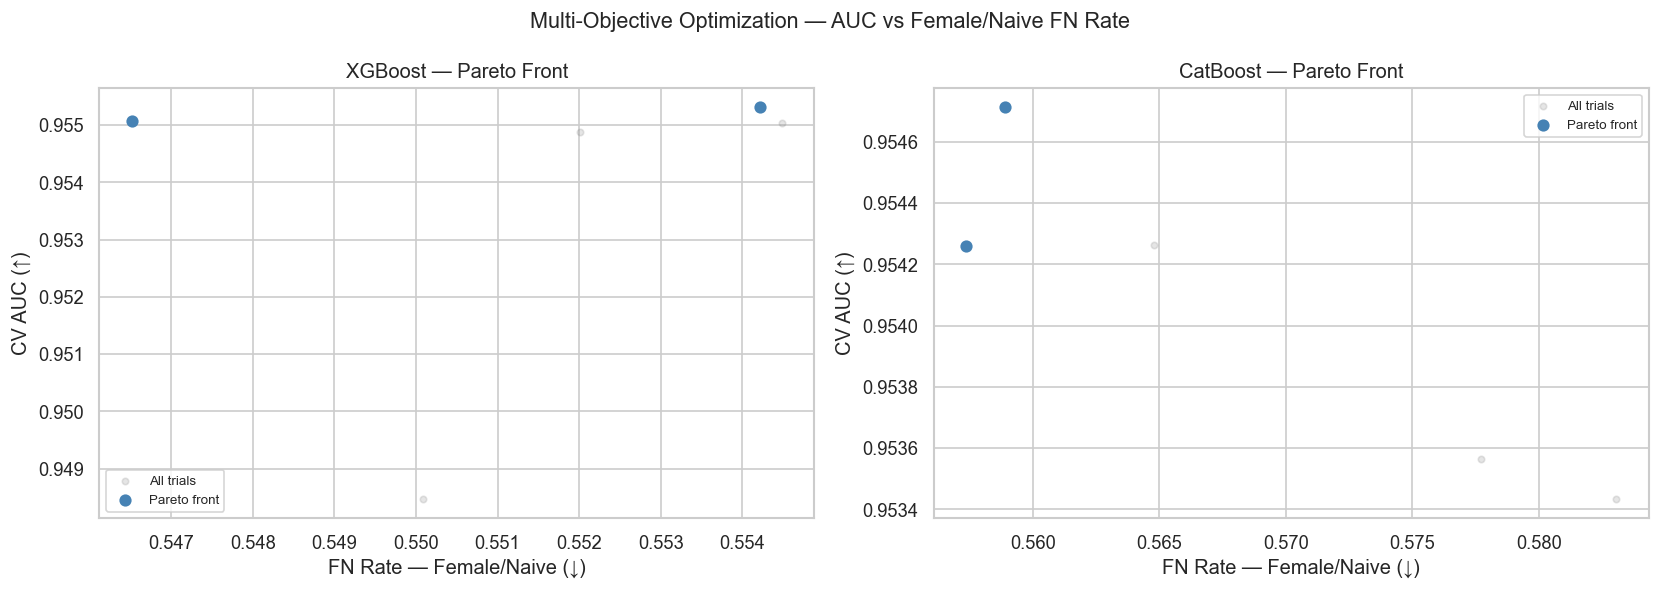

In [8]:
def plot_pareto(study, model_name, ax):
    trials = study.best_trials
    auc_vals = [t.values[0] for t in trials]
    fn_vals  = [t.values[1] for t in trials]

    # All trials (background)
    all_auc = [t.values[0] for t in study.trials if t.values]
    all_fn  = [t.values[1] for t in study.trials if t.values]
    ax.scatter(all_fn, all_auc, alpha=0.2, color='grey', s=15, label='All trials')

    # Pareto front
    ax.scatter(fn_vals, auc_vals, color='steelblue', s=40, zorder=5, label='Pareto front')
    ax.set_xlabel('FN Rate — Female/Naive (↓)')
    ax.set_ylabel('CV AUC (↑)')
    ax.set_title(f'{model_name} — Pareto Front')
    ax.legend(fontsize=8)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_pareto(xgb_study, 'XGBoost',  axes[0])
plot_pareto(cat_study, 'CatBoost', axes[1])
plt.suptitle('Multi-Objective Optimization — AUC vs Female/Naive FN Rate', fontsize=13)
plt.tight_layout()
plt.show()


---
## 7 · Select Best Trials

From the Pareto front, pick the trial that best balances AUC and FN rate.
Strategy: maximize `AUC - penalty * FN_rate` where penalty weights fairness vs performance.

In [9]:
def select_best_trial(study, auc_weight=1.0, fn_penalty=0.5):
    """
    Score each Pareto trial by: auc_weight * AUC - fn_penalty * FN_rate
    Adjust fn_penalty upward to prioritise Female/Naive recall more.
    """
    best_score = -np.inf
    best_trial = None
    for trial in study.best_trials:
        auc, fn = trial.values
        score = auc_weight * auc - fn_penalty * fn
        if score > best_score:
            best_score = score
            best_trial = trial
    return best_trial

xgb_best = select_best_trial(xgb_study, auc_weight=1.0, fn_penalty=0.5)
cat_best  = select_best_trial(cat_study,  auc_weight=1.0, fn_penalty=0.5)

print('=== Best XGBoost Trial ===')
print(f'  AUC:     {xgb_best.values[0]:.4f}')
print(f'  FN rate: {xgb_best.values[1]:.3f}')
print(f'  Params:  {xgb_best.params}')

print('\n=== Best CatBoost Trial ===')
print(f'  AUC:     {cat_best.values[0]:.4f}')
print(f'  FN rate: {cat_best.values[1]:.3f}')
print(f'  Params:  {cat_best.params}')


=== Best XGBoost Trial ===
  AUC:     0.9551
  FN rate: 0.547
  Params:  {'n_estimators': 1148, 'learning_rate': 0.023927528765580644, 'max_depth': 7, 'subsample': 0.569746930326021, 'colsample_bytree': 0.6460723242676091, 'min_child_weight': 8, 'gamma': 2.28034992108518, 'reg_alpha': 0.8431013932082461, 'reg_lambda': 0.0009962513222055108}

=== Best CatBoost Trial ===
  AUC:     0.9543
  FN rate: 0.557
  Params:  {'iterations': 1062, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.09846738873614563, 'bagging_temperature': 0.15601864044243652, 'random_strength': 1.5599452033620265, 'border_count': 45}


---
## 8 · Retrain Best Models & Generate OOF + Test Predictions

In [10]:
X_test = test[FEATURE_COLS].copy()

# ── XGBoost ────────────────────────────────────────────────────────────────
xgb_tuned = XGBClassifier(**xgb_best.params, eval_metric='auc',
                            verbosity=0, random_state=42)

oof_xgb  = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, group_encoded)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    w_train        = sample_weights.iloc[train_idx]

    xgb_tuned.fit(X_train, y_train, sample_weight=w_train,
                  eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = xgb_tuned.predict_proba(X_val)[:, 1]
    test_xgb        += xgb_tuned.predict_proba(X_test)[:, 1] / N_FOLDS

print(f'XGBoost tuned OOF AUC: {roc_auc_score(y, oof_xgb):.4f}')

# ── CatBoost ───────────────────────────────────────────────────────────────
cat_tuned = CatBoostClassifier(**cat_best.params, random_seed=42, verbose=0)

oof_cat  = np.zeros(len(X))
test_cat = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, group_encoded)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    w_train        = sample_weights.iloc[train_idx]

    cat_tuned.fit(X_train, y_train, sample_weight=w_train,
                  eval_set=(X_val, y_val), use_best_model=True, verbose=False)
    oof_cat[val_idx] = cat_tuned.predict_proba(X_val)[:, 1]
    test_cat        += cat_tuned.predict_proba(X_test)[:, 1] / N_FOLDS

print(f'CatBoost tuned OOF AUC: {roc_auc_score(y, oof_cat):.4f}')


XGBoost tuned OOF AUC: 0.9551
CatBoost tuned OOF AUC: 0.9543


---
## 9 · Ensemble & Final Submission

In [11]:
# Simple average ensemble — equal weight since AUCs are nearly identical
oof_ensemble  = (oof_xgb + oof_cat) / 2
test_ensemble = (test_xgb + test_cat) / 2

print(f'Ensemble OOF AUC: {roc_auc_score(y, oof_ensemble):.4f}')

# Per-group evaluation on ensemble
from sklearn.metrics import precision_score

def evaluate_by_group(y_true, y_pred_proba, groups, threshold=0.5):
    y_pred  = (y_pred_proba >= threshold).astype(int)
    results = []
    for group in sorted(groups.unique()):
        mask = groups == group
        yt, yp, ypp = y_true[mask], y_pred[mask], y_pred_proba[mask]
        if yt.nunique() < 2: continue
        tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
        results.append({
            'group':      group,
            'n':          int(mask.sum()),
            'AUC':        round(roc_auc_score(yt, ypp), 4),
            'Recall':     round(recall_score(yt, yp, zero_division=0), 3),
            'FN_rate':    round(fn / max(fn + tp, 1), 3),
        })
    result_df = pd.DataFrame(results).set_index('group')
    print(result_df.to_string())
    return result_df

print('\n=== Ensemble Per-Group Evaluation ===')
evaluate_by_group(y, oof_ensemble, groups)


Ensemble OOF AUC: 0.9550

=== Ensemble Per-Group Evaluation ===
                          n     AUC  Recall  FN_rate
group                                               
Female / Naive        90432  0.9200   0.448    0.552
Female / Surveilled   89285  0.9467   0.771    0.229
Male / Naive         153318  0.9197   0.729    0.271
Male / Surveilled    296965  0.9436   0.926    0.074


,n,AUC,Recall,FN_rate
group,,,,
Female / Naive,90432,0.9200,0.448,0.552
Female / Surveilled,89285,0.9467,0.771,0.229
Male / Naive,153318,0.9197,0.729,0.271
Male / Surveilled,296965,0.9436,0.926,0.074


---
## 10 · Save Submission

In [12]:
submission = pd.DataFrame({
    'id':           test['id'],
    'Heart Disease': test_ensemble
})
submission.to_csv(BASE + 'submission_tuned_ensemble.csv', index=False)
print('✅ Saved submission_tuned_ensemble.csv')
print(submission.head())
print(f'\nPredicted probability distribution:')
print(submission['Heart Disease'].describe().round(3))


✅ Saved submission_tuned_ensemble.csv
       id  Heart Disease
0  630000       0.954943
1  630001       0.007395
2  630002       0.987883
3  630003       0.003801
4  630004       0.207038

Predicted probability distribution:
count    270000.000
mean          0.450
std           0.407
min           0.000
25%           0.037
50%           0.317
75%           0.925
max           1.000
Name: Heart Disease, dtype: float64
